## Pool of low oxygen
Frames and movie

In [12]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import matplotlib.gridspec as gspec

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

In [5]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]
    
hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]

In [33]:
# Cross-shelf velocity, Plot1
def Plot1(gs_ax,t,Tr,xx,zz,Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr: tracer concentration sliced in x-z (nt,nz,nx)
       t: time index.
       xx: x coords, sliced
       yy: y coords, sliced
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(xx/1000,zz,Tr,
                       csU,
                       cmap=cmap_name)
    
    if t == 0:
        cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(1.7,0.0),shrink=1.0)
        cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f',**kw)
    

    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    
    ax.text(1.3,0.1,'Tracer concentration \n (non-dim) \n \n Day %1.1f'%(t/2.),fontsize=12,transform=ax.transAxes)
    
def Plot2(gs_ax,t,Tr,yy,zz,Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(yy/1000,zz,Tr,
                       csU,
                       cmap=cmap_name)
    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
    
def Plot3(gs_ax,t,ConcFilt,xx,yy,xind,yind,depth,minCM=0,maxCM=2):
    
    ax = plt.subplot(gs_ax)
    
    mesh = ax.contourf(xx/1000,yy/1000,ConcFilt,
                       21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap_name2)
    
       
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    ax.text(0.02,0.9,'Shelf bottom',transform=ax.transAxes,color='w')
    SB = ax.contour(xx/1000,yy/1000,
                    depth,
                    [50,75,100,125,150,200,250,300,350,400,450,500],
                    colors=['0.5','0.5','0.5','0.5','0.1','0.5','0.5','0.5','0.5','0.5','0.5','0.5'],
                    linewidths=[0.75] )
    
    
    ax.set_aspect(1)
    ax.set_xlabel('Alongshelf distance (km)',labelpad=0.3)
    ax.set_ylabel('Cross-shelf distance (km)',labelpad=0.3)

In [10]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf))

def PlotBAC(ax,ConcFilt,xslice,yslice,cmap=cmo.cm.tempo, maxCM=9999, minCM=9999):
    
    BAC = ConcFilt[yslice,xslice]
    
    if maxCM == 9999:
        maxCM = np.nanmax(ConcFilt[yslice,xslice])
        minCM = np.nanmin(ConcFilt[yslice,xslice])

    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap)
    
    #cbar_ax = fig.add_axes([0.9, 0.327, 0.015, 0.252])
    #cb=fig.colorbar(mesh, cax=cbar_ax,ticks=[5.2,6.2,7.2,8.2,9.2,10.2],format='%.1f')
    #cb.ax.yaxis.set_tick_params(pad=1)
    fig.colorbar(mesh,ax=ax)
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


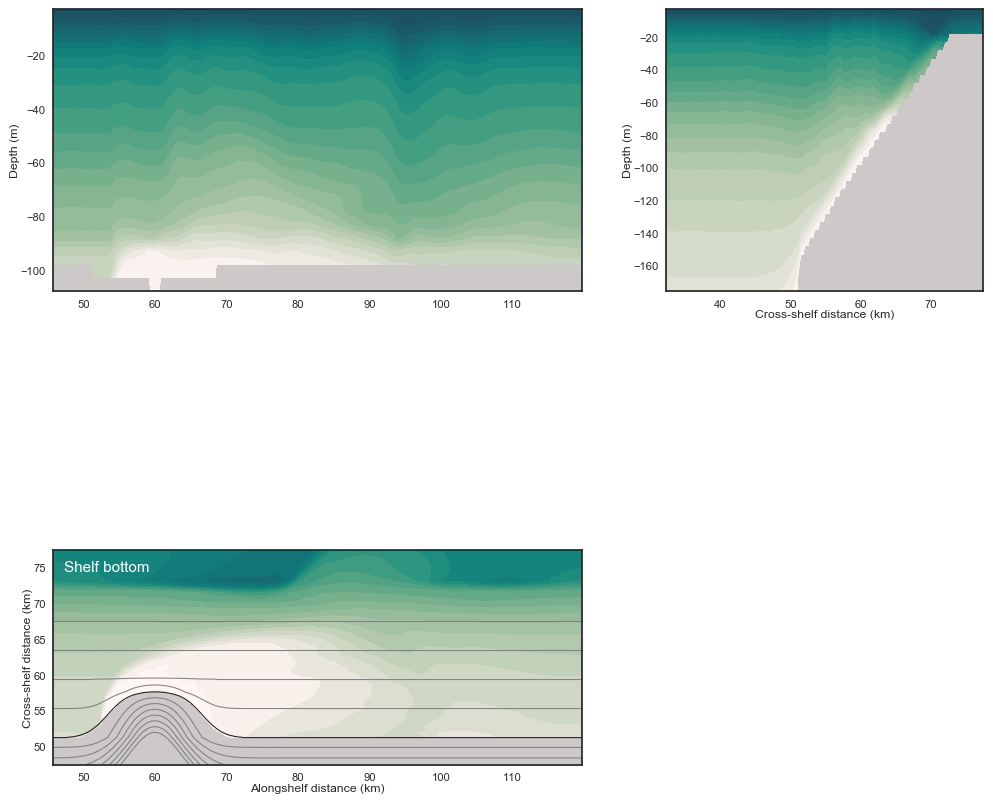

In [37]:
trac = 'Tr03' # Oxygen

xslice=slice(100,360)
yslice=slice(100,330)

xind = 240
yind = 267 # y index for alongshore cross-section
zind = 27

zslice = slice(0,22)

# plot2
zslice_2 = slice(0,35)

# plot 3
yslice_bac = slice(200,330)
xslice_bac = slice(100,360)

tt=6
with Dataset(ptracers_file, 'r') as nbl:
    
    tr = nbl.variables[trac][tt,zslice,yind,xslice] 
    tr_plot1 = np.ma.masked_array(tr, maskC[zslice, yind, xslice])
    
    tr = nbl.variables[trac][tt,zslice_2,yslice,xind]
    tr_plot2 = np.ma.masked_array(tr, maskC[zslice_2,yslice, xind])
    
    concFilt = ConcAreaFunc(nbl.variables[trac][tt,:,:,:],hFacC,rA,Depth)

dpi=300
fig = plt.figure(figsize=(12,12),dpi=dpi)

cmap_name = cmo.cm.tempo
cmap_name2 = cmo.cm.tempo
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 11.0

gs0 = gspec.GridSpec(2, 2, height_ratios=[0.5,1], width_ratios=[1,0.6])
 
Plot1(gs0[0,0],tt,tr_plot1,X[xslice],Z[zslice], Trmin=78, Trmax=300)
Plot2(gs0[0,1],tt,tr_plot2,Y[yslice],Z[zslice_2], Trmin=78, Trmax=300)
Plot3(gs0[1,0],tt,concFilt[yslice_bac,xslice_bac],X[xslice_bac],Y[yslice_bac],
      xind,yind,Depth[yslice_bac,xslice_bac],
      minCM=78,maxCM=300)

In [ ]:
def next_frame(t):
    
    timeIndex = starttime + t 
    data = ConcFilt[timeIndex,yslice_bac,xslice]
    gs0 = gspec.GridSpec(2, 2, height_ratios=[0.5,1], width_ratios=[1,0.6])

    Plot1(gs0[0,0],t,ptracers.Tr1.isel(Y=267),zslice, yind, xslice,Trmin=0.8,Trmax=2.2) # x-z contours conc

    Plot2(gs0[1,1],t,ptracers.Tr1.isel(X=250),yslice_bac,zslice_2,250,Trmin=0.8,Trmax=2.2) # bottom concentration

    Plot3(gs0[1,0],t,np.ma.masked_array(ConcFilt,mask=maskExpandSB),xslice,yslice_bac,250,267,minCM=0.8,maxCM=2.2)

    plt.tight_layout()



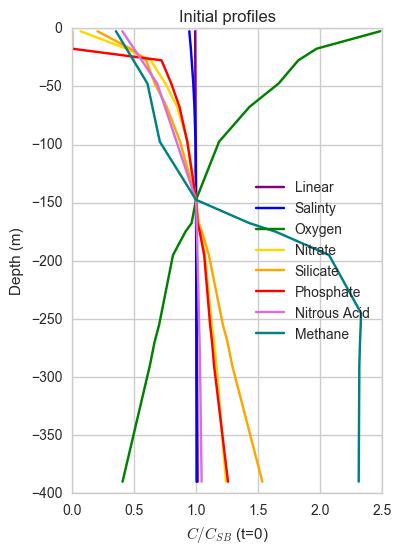

In [5]:
# frames for beamer animation

cmap_name = cmo.cm.tempo
cmap_name2 = cmo.cm.tempo
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0


starttime = 0
data = ConcFilt[starttime,yslice_bac,xslice]
data_all_times = ConcFilt[:,yslice_bac,xslice]


#fig = plt.figure()
f = plt.figure(figsize = (7.4,3)) # 19.0cm = 7.4in, 115cm = 4.52in
   
for tt in range(1):
    
    next_frame(tt)
    frame_name2 = ('/ocean/kramosmu/Figures/PoolOxygen/BottomConc_OxygenNorm_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png')

